In [20]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

In [22]:
# Define the categories
categories = ['gift', 'cargo', 'food', 'equipment', 'document', 'clothing']

# Load the pre-trained ResNet50 model
model = models.resnet50(weights=True)

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier layer with a new one for our categories
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(categories))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters())
#optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01)

In [24]:

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [25]:
# Define the data directory
data_dir = 'data'

# Load the dataset using ImageFolder
dataset = ImageFolder(root=data_dir, transform=preprocess)

train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset)-int(len(dataset)*0.2), int(len(dataset)*0.2)])

In [26]:
# DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
# Create lists to store accuracy and loss values
accuracy_list = []
loss_list = []
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    # Train for one epoch
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validate the model
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy_list.append((correct/total)*100)
    loss_list.append(loss.item())
    
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs, loss.item(), (correct/total)*100))



Epoch [1/10], Loss: 0.2303, Accuracy: 91.06%
Epoch [2/10], Loss: 0.4216, Accuracy: 93.50%
Epoch [3/10], Loss: 0.2748, Accuracy: 94.31%
Epoch [4/10], Loss: 0.5282, Accuracy: 95.12%
Epoch [5/10], Loss: 0.1946, Accuracy: 94.31%
Epoch [6/10], Loss: 0.4991, Accuracy: 95.12%
Epoch [7/10], Loss: 0.1796, Accuracy: 93.50%
Epoch [8/10], Loss: 0.1937, Accuracy: 95.12%
Epoch [9/10], Loss: 0.3213, Accuracy: 95.12%
Epoch [10/10], Loss: 0.0933, Accuracy: 94.31%


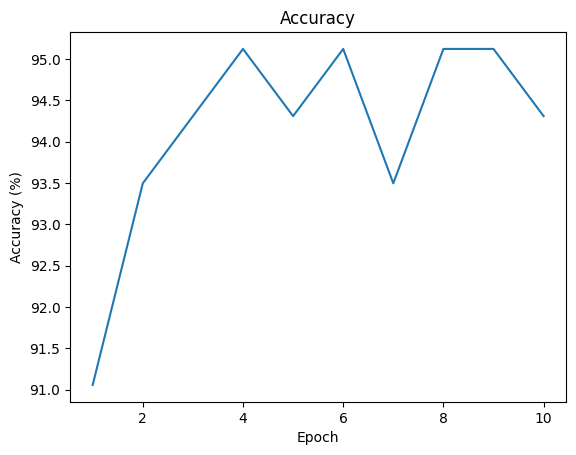

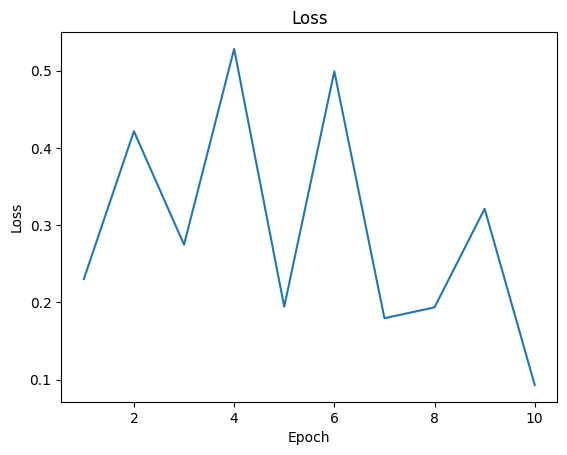

In [40]:
import matplotlib.pyplot as plt
# Plot accuracy
plt.plot(range(1, num_epochs+1), accuracy_list)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()

# Plot loss
plt.plot(range(1, num_epochs+1), loss_list)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [18]:
# Save the model
torch.save(model.state_dict(), 'model.pth')